# ADS Take Home Assignment

## Alex Vand - Associate Data Scientist

# Purpose of Assignment

The goal of this assignment is to QA/QC, analyze, and draw insights from geologic data.

First, import the necessary packages to complete the assignment.

In [408]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg # to display map images during geospatial analysis
from statsmodels.formula.api import ols # for statistical analysis

Next, read in the raw dataframe.

In [316]:
df = pd.read_csv("kobold_data\ADS_Exercise_data\MN_geochem_ads.csv") # read in the raw dataframe

The following code chunk displays exploratory information about the dataframe.

In [317]:
df.info(memory_usage='deep') # view basic exploratory information about the dataframe including column names and data types
# 'deep' does a real calclulation of the memory usage, instead of estimated

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sample          305 non-null    int64  
 1   medium          305 non-null    object 
 2   easting_wgs84   305 non-null    float64
 3   northing_wgs84  304 non-null    float64
 4   date_assay      305 non-null    object 
 5   company         305 non-null    object 
 6   structure       110 non-null    object 
 7   lithology       289 non-null    object 
 8   Co_ppm          302 non-null    float64
 9   Cu_ppm          242 non-null    float64
 10  Ni_ppm          305 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 127.1 KB


This rawa dataset contains 11 columns (variables of interest) and 305 rows (observations or potential mining locations). Additionally, there are both numerical (float64 and int64) and string (object) data types.

As shown in the output above under "Non-Null Count", several variables contain less than 305 non-null entries. This indicates there are several null, NA, or blank variables that must be accounted for.

The first task of this assignment is to clean the raw dataset so that later we can perform statistical and geospatial analysis.

# Data Cleaning

To clean this dataset, duplicate values must be removed, any incorrect data points must be fixed, and NA values must be addressed. Various programmatical tests, as well as general data exploration, will be incorporated to determine if any data points were inputted in error.

## Duplicates

The "sample" ID column is the unique key to identify each data point. Therefore, we can use this column to search for any duplicate entries in the data set and delete those rows. The code belows displays all the duplicate values. There are 7 total data points from the raw dataset that have duplicate sample numbers.

In [318]:
df[df.duplicated(['sample'], keep=False)] # "keep = false" displays all duplicates instead of ignoring the first or last

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
223,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basaltt,42.0,100.0,41
233,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt.,59.0,83.0,172
300,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,36.0,110.0,41
301,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,52.0,58.0,242
302,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,Basalt,42.0,100.0,41
303,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41
304,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41


Sample 9497291 has all the same values, for all variables, for all 4 duplicate entries [indices 223, 302, 303, 304]. Therefore, we can delete all repeated duplicates and just keep the first entry, as is done in the code chunk below.

In [319]:
# drops duplicate row across all variables and updates dataframe
df.drop_duplicates(subset=['sample','Co_ppm','Cu_ppm','Ni_ppm'], keep='first', inplace=True)
df.shape

(302, 11)

The dataframe now has 302 rows, which means 3 repeated observations for sample 9497291 were deleted, as expected.

Sample 9497345, however, has different values for the metal concentrations for all 3 duplicate entries [indices 233, 300, 301]. This implies we cannot keep any of the 3 data points in our dataframe as we do not know which one is correct. If possible, we could refer to the metadata or ask the field team to answer any potential questions. Given the resources currently availalbe, we could consider taking the average value of the 3 duplicate data entries and including that number in our clean dataset. Alternatively, another potential option is to assign a new sample number or identifier to each of the duplicate samples that have different mineral concentration values. For example, indices 300 and 301 could be assigned new sample numbers and those data points could be included in the final clean dataset. However, since these 3 data points have the same GPS coordinates, it is not logical to keep all three values for the same location. These data points will be considered NA values, and will therefore be omitted during analysis. 

In [320]:
# drops duplicate row across all variables and updates dataframe
df.drop_duplicates(subset=['sample'], keep=False, inplace=True)
df.shape

(299, 11)

The dataframe now has 299 rows, which means the 3 observations for sample 9497345 were deleted, as expected.

In the next section, we will visit some data entry errors and rectify the apparent mistakes and typos.

## Latitude and Longitude Errors

There are several data points where the latitude ("northing_wgs84") and longitude ("easting_wgs84") are flipped and/or one of the values has the incorrect positive or negative sign. These data points must be corrected so they can be included in the calculations for spatial analysis. Below we see a map of all of our raw data points.

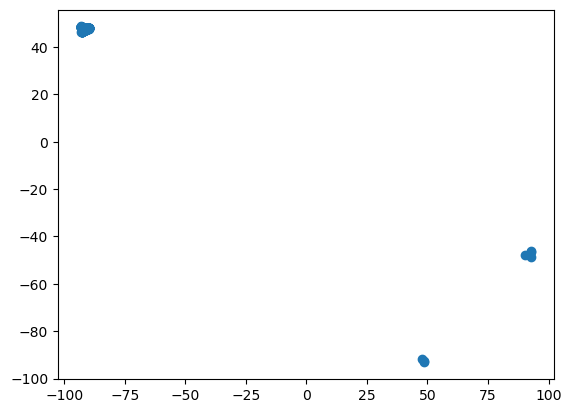

In [321]:
plt.scatter(df['easting_wgs84'], df['northing_wgs84'])

At first glance, it looks like the data cover three distinct geographical regions. However, upon closer examination of the northing and easting data, it becomes apparent that some of these data points might have been inputted in the wrong column.

In [322]:
easting_min = df['easting_wgs84'].min()
easting_max = df['easting_wgs84'].max()

print("The range for 'easting_wgs84' is between", easting_min, "and", easting_max, "degrees.")

The range for 'easting_wgs84' is between -93.35 and 92.93611 degrees.


In [323]:
northing_min = df['northing_wgs84'].min()
northing_max = df['northing_wgs84'].max()

print("The range for 'northing_wgs84' is between", northing_min, "and", northing_max, "degrees.")

The range for 'northing_wgs84' is between -93.2 and 48.66667 degrees.


First we will swap any latitude ("northing_wgs84") and longitude ("easting_wgs84") points that appear to be in the opposite column. The following code chunk displays the data points where this switch may need to take place.

In [324]:
df.loc[(abs(df['easting_wgs84']) < (abs(df['easting_wgs84']).mean())*0.90)] # lists the data points where lat & long need to swap

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
21,9177307,rock_outcrop,48.41581,-92.52700,11/6/01,united_states_geological_survey,pluton; stock,granite,3.0,4.0,<1.5
70,9278672,rock_outcrop,48.63333,-93.20000,11/14/83,united_states_geological_survey,xenolith,diorite,66.0,43.0,640
161,9334348,rock,47.61861,-91.93222,1/2/88,united_states_geological_survey,NaN,gabbro,22.5,75.0,75


Next, we will update the dataset and actually switch the northing and easting values for all three data observations listed above.

In [325]:
df[['easting_wgs84','northing_wgs84']] = df[['northing_wgs84',
                                             'easting_wgs84']].where(abs(df['easting_wgs84']) < (abs(df['easting_wgs84']).mean())*0.90,
                                                                         df[['easting_wgs84','northing_wgs84']].values)

Here we multiply the absolute value of the easting value by -1 to make sure all the longitude values are negative and reflect the same geographic location in the Western Hemisphere.

In [326]:
df['easting_wgs84'] = df['easting_wgs84'].apply(abs)*(-1) # ensures that all longitude values are negative (degrees west)

Below we find the absolute value of all northing values to make sure all the latitude values are positive and reflect the same geographic location in the Northern Hemisphere.

In [327]:
df['northing_wgs84'] = df['northing_wgs84'].apply(abs) # ensures that all latitude values are positive (degrees north)

In the map below, using the updated dataframe, we see that all data points are relegated to the same geogaphical area in North America.

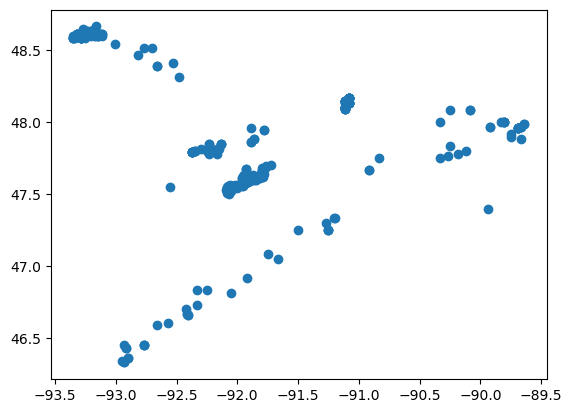

In [328]:
plt.scatter(df['easting_wgs84'], df['northing_wgs84'])

## NA Values

The following code chunk will display the current total number of null (blank) values in the raw dataset.

In [329]:
print(df.isna().sum()) # counts the number of NA (null) values in each column

sample              0
medium              0
easting_wgs84       0
northing_wgs84      1
date_assay          0
company             0
structure         195
lithology          16
Co_ppm              3
Cu_ppm             63
Ni_ppm              0
dtype: int64


Taking a closer look at the mineral concentration values, it becomes apparent that several data points must be fixed, updated, or assigned an NA value.

In [330]:
cobalt_min = df['Co_ppm'].min()
cobalt_max = df['Co_ppm'].max()

print("The range for cobalt is between", cobalt_min, "and", cobalt_max, "ppm.")

The range for cobalt is between -0.1 and 768.0 ppm.


For example, because these ranges of values represent mineral concentrations, negative values are nonsensical. We might make the choice to consider all negative values as NA; however, since the negative values included in this column are within a reasonable range if they were positive, we will convert these values to positive numbers in a later step and keep them for our future analysis.

In [331]:
copper_min = df['Cu_ppm'].min()
copper_max = df['Cu_ppm'].max()

print("The range for copper is between", copper_min, "and", copper_max, "ppm.")

The range for copper is between -99999.0 and 99999.0 ppm.


Furthermore, here we see that the copper values include common NA identifiers such as -99999 and 99999. We must convert these values to NA, as is done in the code chunk below.

In [332]:
df[['Cu_ppm']] = df[['Cu_ppm']].mask(abs(df[['Cu_ppm']]) == 99999) # changes -99999 and 99999 values to NA

In [333]:
nickel_min = df['Ni_ppm'].min()
nickel_max = df['Ni_ppm'].max()

print("The range for nickel is between", nickel_min, "and", nickel_max, "ppm.")

The range for nickel is between -1.25 and <1.5 ppm.


Additionally, the nickel data column has a string (word) value listed for very low concentrations ("<1.5") instead of a number. One option to incorporate these data points with very low nickel concentration is to convert "<1.5" to an arbitrary numerical value by assigning a random low number that is less than 1.5. However, because too many assumptions must be made to justify assigning new values, these data points will be considered null and will be omitted from analysis, shown below.

In [334]:
df[['Ni_ppm']] = df[['Ni_ppm']].mask(df[['Ni_ppm']] == "<1.5") # changes <1.5 values to NA
df.Ni_ppm = df.Ni_ppm.astype(float) # converts data type to float so that absolute value function can be used in next code chunk

Finally, now that several NA issues have been addressed, the code chunk below changes all mineral concentration values to be positive.

In [335]:
df[['Co_ppm','Cu_ppm','Ni_ppm']] = df[['Co_ppm','Cu_ppm','Ni_ppm']].apply(abs)

Notice that the total count of NA values has increased, as is shown in the output below. Cu_ppm gained 2 NA datapoints (previously 99999 and -99999) and Ni_ppm gained 6 NA data points (previoysly "<1.5").

In [336]:
print(df.isna().sum()) # counts the number of NA (null) values in each column

sample              0
medium              0
easting_wgs84       0
northing_wgs84      1
date_assay          0
company             0
structure         195
lithology          16
Co_ppm              3
Cu_ppm             65
Ni_ppm              6
dtype: int64


## Fixing Lithology Data Entry Typos

Next, let's investigate the values for the categorical variables "structure" and "lithology".

First, we fill in all blank lithology data points with the word "unknown" so that we can systematically address any typos across the lithology variable.

In [337]:
df.lithology.fillna(value = "unknown", inplace = True) # change NA values in "Lithology" column to "unknown" string

The same can be done for the "Structure" variable, but it is worth mentioning that a blank data point or value does not necessarily indicate an "unknown" value. However, in order to use certain functions that allow the manipulation of these data columns, we must convert the NA values to a string value (hence "unknown" has been chosen here).

In [338]:
df.structure.fillna(value = "unknown", inplace = True) # change NA values in "Structure" column to "unknown" string

In [339]:
np.unique(df['lithology']) # this only works after using fillna function to add "unknown" string

array(['Basalt', 'CHERT', 'DACITE', 'GABBRO', 'GRAYWACKE', 'andesite',
       'argillite', 'basalt', 'basalt.', 'basaltt', 'bassalt', 'dacite',
       'diorite', 'felsic', 'gabbro', 'gabro', 'granite', 'granodiorite',
       'greenstone', 'hornfels', 'meta-andesite', 'meta-graywacke',
       'metafelsite', 'metagraywacke', 'metasediment', 'metasiltstone',
       'monzonite', 'none', 'pegmatite', 'rhyolite', 'sandstone',
       'schist', 'shale', 'siliciclastic', 'tuff', 'unknown'],
      dtype=object)

From viewing all possible values for lithology above, we can see that there are several data entry mistakes. We need each of these values to be consistent so that they will be appropriately accounted for during analysis. In order to create consistency across the entire variable, the following code chunk changes all lithology types to lower case letters.

In [340]:
df.lithology = df.lithology.str.lower() # change all lithology types to lower case letters for uniformity

The following code chunks replace all typos in the dataset for the different lithologies. Another option is to write a function using an if-statement that includes a regular expression or advanced search string to correct each of the lithology typos.

In [341]:
df.lithology.replace(('Basalt','basalt.','bassalt','basaltt'), 'basalt', inplace = True) # fix all "basalt" typos

In [342]:
df.lithology.replace(('GABBRO', 'gabro'), 'gabbro', inplace = True) # fix all "gabbro" typos

In [343]:
df.lithology.replace('meta-andesite', 'metaandesite', inplace = True) # delete the dash for consistency in lithology names

In [344]:
df.lithology.replace('meta-graywacke', 'metagraywacke', inplace = True) # delete the dash for consistency in lithology names

In [345]:
df.lithology.replace('none', 'unknown', inplace = True) # change "none" to "unknown" for consistency

After addressing the various typos, all lithology values are consistent and there are no longer any repeat categories. 

In [346]:
np.unique(df['lithology']) # this only works after using fillna function to add "unknown" string

array(['andesite', 'argillite', 'basalt', 'chert', 'dacite', 'diorite',
       'felsic', 'gabbro', 'granite', 'granodiorite', 'graywacke',
       'greenstone', 'hornfels', 'metaandesite', 'metafelsite',
       'metagraywacke', 'metasediment', 'metasiltstone', 'monzonite',
       'pegmatite', 'rhyolite', 'sandstone', 'schist', 'shale',
       'siliciclastic', 'tuff', 'unknown'], dtype=object)

# Statistical Analysis

## Comparing Basalt and Gabbro

In this section, we are interested in determining whether basalt or gabbro is more prosperous when mining for cobalt and nickel. In order to perform this statistical analysis, first, we will subset the clean dataframe to include only lithologies with basalt and gabbro. The new subsetted dataframe should contain 97 rows.

In [347]:
df_subset = df[df['lithology'].isin(['basalt', 'gabbro'])] # should contain 97 rows
df_subset.to_csv('kobold_data\kobold_data_clean_subset.csv') # writes a copy of the clean subsetted data to the repo directory
print(df_subset.shape)

(97, 11)


This statistical analysis will implement ordinary least squares regression (OLS) analysis using the subsetted dataframe. In order to perform OLS (ordinary least squares) regression with categorical data, we need to assign dummy variables to our variable of interest ("lithology"). Basalt is assigned the value of 1 (or True) and Gabbro is assigned 0 (or False) in the code chunk below.

In [365]:
# updates lithology column with binary numerical values
df_subset.lithology.replace("basalt", 1, inplace=True)
df_subset.lithology.replace("gabbro", 0, inplace=True)

C:\Users\Alex Vand\AppData\Local\Temp\ipykernel_29972\807357271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.lithology.replace("basalt", 1, inplace=True)
C:\Users\Alex Vand\AppData\Local\Temp\ipykernel_29972\807357271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.lithology.replace("gabbro", 0, inplace=True)


The following code chunk runs an OLS regression analysis to determine which lithology is more prospective for cobalt. The slope coefficient value [-100.1294] for this regression analysis is negative. The negative slope value implies that when basalt (lithology = True) is accounted for, the average mineral concentration value decreases compared to data points with gabbro lithology (lithology = False). This implies that gabbro lithology is more prospective for mining cobalt. The p-value is low very close to zero, so this slope coefficient is statistically significant.

In [370]:
# Cobalt regression analysis
model = ols('Co_ppm ~ lithology', data=df_subset)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Co_ppm   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     36.04
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           3.51e-08
Time:                        12:47:53   Log-Likelihood:                -564.19
No. Observations:                  97   AIC:                             1132.
Df Residuals:                      95   BIC:                             1138.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.5500     11.609     13.140      0.000     129.502     175.598
lithology   -100.1294     16.678     -6.004      0.000    -133.240     -67.019
==============================================================================
Omnibus:                      127.380   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4304.878
Skew:                           4.312   Prob(JB):                         0.00
Kurtosis:                      34.476   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The same OLS regression analysis for nickel is completed below. Again we see that the slope coefficient value [-198.0451] is negative and the p-value is zero. For nickel, similar to cobalt, the negative slope value implies that gabbro lithology is more prospective.

In [369]:
# Nickel regression analysis
model = ols('Ni_ppm ~ lithology', data=df_subset)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ni_ppm   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     18.10
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           4.91e-05
Time:                        12:47:49   Log-Likelihood:                -663.75
No. Observations:                  97   AIC:                             1331.
Df Residuals:                      95   BIC:                             1337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    351.0600     32.403     10.834      0.000     286.732     415.388
lithology   -198.0451     46.550     -4.254      0.000    -290.459    -105.632
==============================================================================
Omnibus:                       43.634   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.937
Skew:                           1.598   Prob(JB):                     5.48e-27
Kurtosis:                       7.440   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that it has been determined that gabbro lithology is more prospective than basalt, let's view the mineral data spatially to gain a better understanding of optimal mining locations.

# Geospatial Analysis

In this section, we will view the cobalt and nickel geochemistry data over a magnetic intensity ratster with the goal of highighting three prospective mining areas.

Most of the following spatial analysis was completed in QGIS, although similar maps could have been created reproducibly using Python packages such as `geopandas` and `rasterio`. I decided to take this opportunity to display mapping skills in QGIS, since Python coding skils were demonstrated through data cleaning and statistical analysis.

The image below displays two side-by-side maps, one for cobalt and one for nickel, overlaid on the total magnetic intensity (TMI) image that was provided. The data points only include gabbro and basalt lithologies.

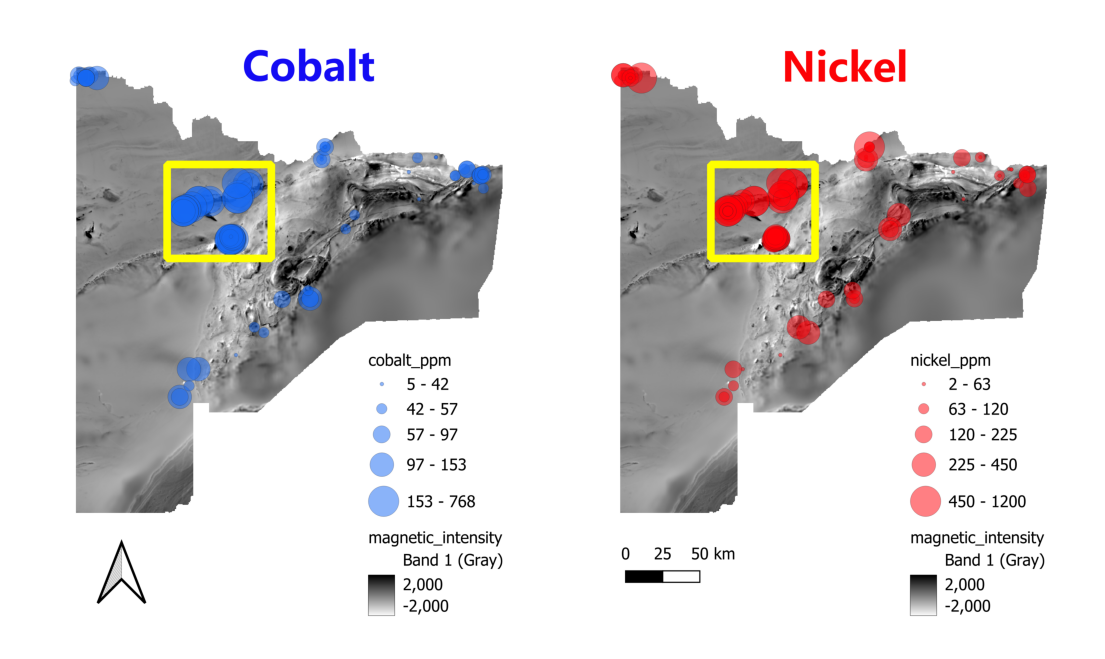

In [407]:
# displays cobalt and nickel side-by-side map image
co_ni_map = mpimg.imread("maps\co_ni_map.png",)
plt.figure(figsize=(14, 10))
plt.axis('off')
plt.imshow(co_ni_map)
plt.show()

As shown in the legend above, cobalt data points are shown in blue and nickel in red. The data markers increase in size according to the amount of mineral concentration found at each particular GPS point. The black and white TMI image displays darker areas as regions with higher magnetic intensity. Most of the points with high concentrations of both cobalt and nickel are located in the same region shown in the maps above in the yellow bounding box. Next, let's combine these two cobalt and nickel maps and zoom in closer to adjust the resolution of the .tiff image to gain a better understanding of highly prospective mining regions.

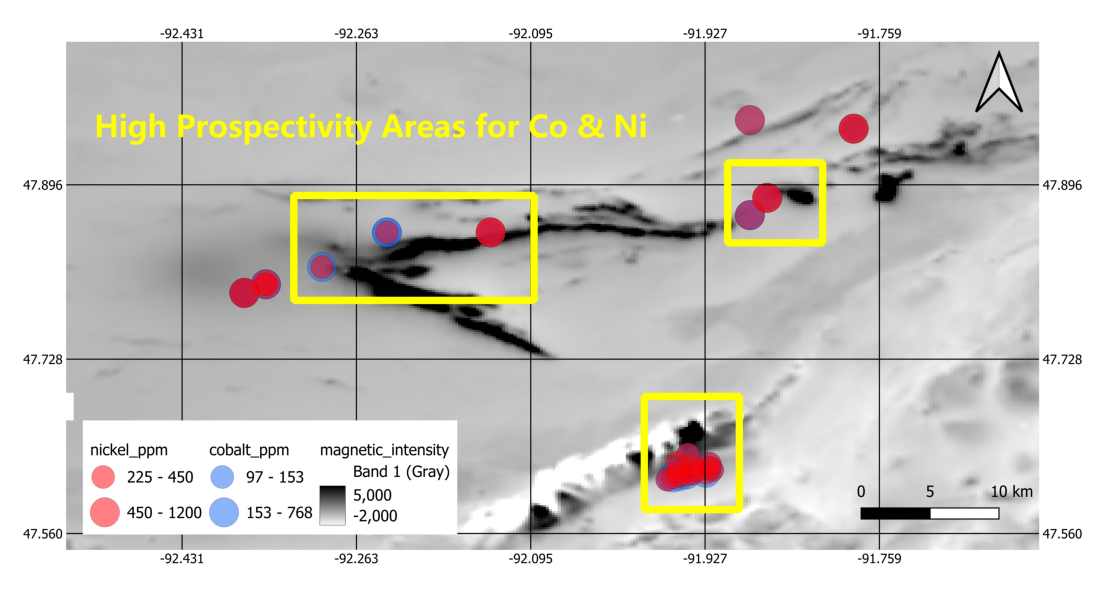

In [405]:
# displays zoomed-in map image
zoomed_in_map = mpimg.imread("maps\zoomed_in_map.png")
plt.figure(figsize=(14, 10))
plt.axis('off')
plt.imshow(zoomed_in_map)
plt.show()

According to the map above, there are several regions where high mineral concentrations overlap with high magnetic intensity. These regions are considered highly prospective mining areas, shown with yellow boxes in the map image above.

# Future Research

Given more time, I would have liked the opportunity to create an interactive map, where layers could be added or removed and the user could zoom in and out. Furthermore, I would be interested in adding additional layers to the maps in the spatial analysis section (for example: soil types) to further determine which areas would be best for mining. Additionally, more comprehensize (but possibly less efficient) functions could be written in the data cleaning section to fix data entry errors. For example, a search string with a regular expression might be an even better option to search for lithology typos.

# Summary

In summary, the goal of this project was to display applicable data skills by analyzing optimal mining locations for cobalt and nickel. In order to do so, spatial geochemistry data was cleaned and subsetted reproducibly in Python. Statistical analysis, more specifically OLS regression, was implemented to ascertain that gabbro lithology is more prospective compared to basalt. Finally, maps were created to compare TMI to further highlight optimal mining regions for cobalt and nickel.